#Preliminary

Imports:

In [1]:
import math
import random
import numpy as np
import networkx as nx
import networkx.algorithms.cycles as cyc
import networkx.algorithms.dag as dag
import matplotlib.pyplot as plt

#3-Connectedness and st-Orientation

A graph G is *3-connected* if any 2 verteces in G can be deleted without disconnecting it. 

An *st-orientation* or *bipolar orientation* of a graph G is an assignment of a direction to each edge (an orientation) that causes G to become a directed acyclic graph with a single source s and a single sink t. An *e-bipolar orientation* of G is an st-orientation where e = (s, t) is an edge in G.





There exists an interesting relationship between 3-connectivity and st-orientations. First, we outline some theorems:


---

**Construction of 3-Connected Graphs:**

**Theorem 1 (Tutte)**: *Suppose we are given a complete list Lm of the (non-isomorphic) simple 
3-connected graphs of m edges, (where m> 3). Then, any graph G derived from H ϵ Lm by one of the following two operations must be in Lm+1:*

*(I) Adjoining to H a new edge A whose ends are two distinct members 
of V(H) not joined in H,* 

*(II) "Splitting" a vertex x of H incident with 4 or more edges, and 
adjoining A = {u, v} as an edge incident with the two resulting new vertices u and v. The edges incident with x are split into two classes U and V, such that |U|, |V| ≥ 2. After splitting, the edges in U and V are made incident to u and v, respectively.*

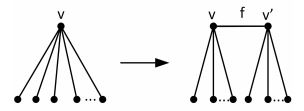

Figure: Vertex Splitting Operation (Costalonga et al)



---

**On deletable, contractable, and invertible edges**

The graph G\f will denote the one resulting from the *deletion* of an edge f from the graph G. 
An edge f is said to be *contracted* if it is deleted and its ends are indentified: the resulting graph is denoted G/f.


**Note:** *Edge deletion and contraction can be thought of as the "inverse" operations of operations I) and II) for constructing 3-connected graphs, respectively.*


**Definition 1**: Given an e-bipolar orientation of a graph G, an edge f (where e != f) is:

*   *deletable* if the induced orientation G\f is an e-bipolar orientation
*   *contractable* if the induced orientation of G/f is an e-bipolar orientation
*   *invertible* if G is e-bipolar oriented whatever the orientation of f


**Lemma 1 (Fraysseix et al)**: *Consider an edge f = (u, v):* 
*   *f is not deletable if an only if u has no other outgoing edge than f, or v has no other incoming edge than f.*
*   *f is not contractable if and only if there exists an oriented path from u to v besides f.*


**Corollary 1**: *For an edge f = (u, v):*
*   *f is deletable iff u and v have more than 1 outgoing and incoming edge, respectively.*
*   *f is contractable iff there does not exist an oriented path from u to v besides f.*


**Lemma 2 (Fraysseix et al)**: *If f is not contractable, f must be deletable*


**Corollary 2**: *If f is not deletable, it must be contractable*


**Theorem 2 (Fraysseix et al)**: *Let f != e be an edge of an e-bipolar orientated graph G. The edge f is deletable, contractable, or both. Moreover, f is invertible if and only if it is both deletable and contractable.*






---







**Connectiveness of the e-bipolar orientations**

Let e be an edge of a 2-connected graph G, with a prescribed orientation. Two e-bipolar orientations of G are said to be adjacent if they differ in the orientation of a single edge. This relation on the e-bipolar orientations of G defines the *adjacency graph* Be(G). By the connectiveness of Be(G), we mean that two e-bipolar orientations O and O' of G can be obtained from each other by a sequence of edge invertions, each intermediate orientation of G being e-bipolar.

**Theorem 2 (O. de Mendez)**: *Let G be a 3-connected graph and e an oriented edge of G, then the graph Be(G) is connected.*



---



Thus, we see that:

1.   We can construct new 3-connected graphs with edge insertions and vertex splittings of an existing 3-connected graph.
2.   We can preverve st-orientation for subgraphs of an st-oriented graph G created with edge deletions and edge contractions (the inverse operations to the ones used in 3-connected graph construction), if the edges meet certain criteria.
3.   Every edge in an st-orientation is deletable, contractable, or both.
4.   If an edge in an st-orientation of G is both deletable and contractable, it is invertible, and inverting it yields a new st-orientation of G.
5.   All of the st-orientations of a 3-connected graph can be derived by an initial st-orientation and a sequence of edge invertions.

It would be useful if a 3-connected graph H constructed from a 3-connected graph G could be given an st-orientation, and then have the steps in the construction from G to H undone, while preserving st-orientation (ending in an st-orientation for the original graph G). In other words: 

*Is the sequence of operations in the construction of H always reversible while still preserving st-orientation? If not generally, what conditions must be added to the construction to guarantee this?*


In this notebook, we also consider *minimally 3-connected graphs*. A minimally 3-connected graph is a 3-connected graph where, if any 1 edge were to be deleted, the resulting graph would no longer be 3-connected. Since 3-connectedness is a useful property to preserve, and edge deletions are an operation in st-orientation preservation, these form an interesting base case. We cannot delete an edge wihout destroying 3-connectivity, and thus destroying the accessibility of all other possible st-orientations via edge inversion.

An edge f of a 3-connected graph is said to be *essential* if neither G\f nor G/f are 3-connected (Fraysseix). In minimally 3-connected graphs, for all edges f, G/f is not 3-connected. It is natural to wonder what about the other condition of essentiality, that of G\f being 3-connected. We will call a graph where every edge f is essential an *essentially 3-connected graph.*

#Implementation of Plestenjak's 3-Connected Planar Graph Drawing Algorithm

In the paper, Plestenjak presents this algorithm to draw planar, 3-connected graphs. It works for other kinds, however, as long as they have at least 1 cycle. The chosen source node for ``` find_cycle()``` would need to be in said cycle, however. Thus, maybe another way for finding a cycle would be better.


In [2]:
#testing Tutte Graph
G = nx.tutte_graph() #[0, 1, 2, ..., 44, 45]
n = G.number_of_nodes()

#recommended parameters
def C(n):
  return math.sqrt(n / math.pi)
def cool(n):
  return lambda i: math.sqrt(math.pi / n) / ((1 + (math.pi / n) * i ** (3 / 2)))
 
def longest_cycle(G):
    #find the biggest cycle in G
    all_loops = [list(nx.find_cycle(G, source=v)) for v in G.nodes]
    a = sorted(all_loops, key = lambda s: len(s)) 
    print(list(a))
    longest = [e[0] for e in a[-1]]
    return longest
    
def length_cycle(G, length):
    #find the biggest cycle in G
    basis = nx.cycle_basis(G)
    print(list(basis))
    valid_loops = [c for c in basis if len(c)==length]
    if valid_loops:
        return random.choice(valid_loops)
    else:
        print(f"no basis with length {length} found")
        return longest_cycle(G)

#actual algorithm, adds the coordinates to each node. We can automate the maxIteration
def PlanarEmbed(G, max, C=C(n), cool=cool(n), source=None, outerCycle=None): #default parameters for easy use
    #at the moment, find longest cycle
    if source != None:
        outer = cyc.find_cycle(G, source=source)
    elif outerCycle == None:
        outer = longest_cycle(G)
    else:
        outer = outerCycle
    #get inner and outer node sets
    outerNodes = outer
    innerNodes = [v for v in G.nodes if not v in outerNodes]
 
    #step 1
    q = len(outerNodes)
    for i in range(q): #for outer nodes, unit circle coordinates
        v = outerNodes[i]
        angle = (2 * math.pi * i) / q
        x, y = math.cos(angle), math.sin(angle)
        G.nodes[v]["position"] = np.array([x, y], dtype=float)
 
    for v in innerNodes: #for inner nodes, zero vector coordinate
        G.nodes[v]["position"] = np.zeros(2, dtype=float)
 
    #step 2
    for i in range(max):
        for v in G.nodes: #a: set the force to 0 for all v
            G.nodes[v]["force"] = np.zeros(2, dtype=float)
        
        for e in G.edges: #b: adjust force for inner and outer v
            u = e[0]
            v = e[1]
            posv = G.nodes[v]["position"]
            posu = G.nodes[u]["position"]
            F = C * np.power((posv - posu), 3)
            G.nodes[u]["force"] += F
            G.nodes[v]["force"] -= F
        
        for v in innerNodes: #c: move coordinates for inner v
            F = G.nodes[v]["force"]
            d = np.linalg.norm(F)
            if (d > 0): #avoids div by 0, not all inner are neighbors to outers
                displacement = (min([d, cool(i)]) / d)
                G.nodes[v]["position"] += displacement * F 
 
def PlotGraph(G, s=None, t=None):
    for e in G.edges:
        color = "black"
        u = e[0]
        v = e[1]
        if (u == s or v == s or u == t or v == t):
            color = "red"
        pos1 = G.nodes[u]["position"]
        pos2 = G.nodes[v]["position"]
        x1, x2 = pos1[0], pos2[0]
        y1, y2 = pos1[1], pos2[1]
        plt.plot([x1, x2], [y1, y2], 'go-', color=color, markersize=2.7, linewidth=1)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

def PlotDirectedGraph(G, s, t):
    for e in G.edges:
        u = e[0]
        v = e[1]
        color = "blue"
        if (u == s or v == t):
            color = "red"
        pos1 = G.nodes[u]["position"]
        pos2 = G.nodes[v]["position"]
        x1, x2 = pos1[0], pos2[0]
        y1, y2 = pos1[1], pos2[1]
        plt.plot(x1, y1, "go--", markersize=2.7, color=color, label=u)
        plt.plot(x2, y2, "go--", markersize=2.7, color=color, label=v)
        plt.arrow(x1, y1, x2-x1, y2-y1, 
                  color="black",
                  length_includes_head=True,
                  linewidth=0.5,
                  head_width=0.03, 
                  head_length=0.05)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

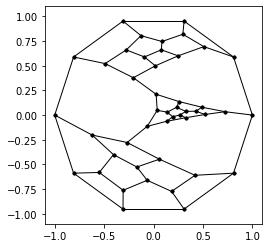

In [ ]:
PlanarEmbed(G, 256)
PlotGraph(G)

Since the function ```find_cycle()``` finds the longest cycle starting from the source, hamiltonian graphs produce uninteresting embeddings due to **every** vertex being in the outer unit circle. This likely produces a self-intersecting embedding of a planar graph.

For example, the embedding of the dodecahedral graph:

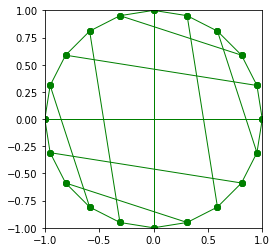

#3-connected Planar Graph Constructor

We utilize the work of Costalonga et al, contained in the repository http://github.com/rkingan/m3c.


In the repository is provided a database of minimally 3-connected graphs. A minimally 3-connected graph is a 3-connected graph where, if any 1 edge were to be deleted, the resulting graph would no longer be 3-connected. We use these graphs as a base to construct other 3-connected graphs, due to this property.

In [ ]:
!git clone http://github.com/rkingan/m3c
!pip install pynauty python-igraph

Filter all possibly planar graphs from the m3c repo

In [ ]:
import tempfile
import os

counter = 0
!rm /content/planar-minimally-3-connected/m3c*
!mkdir planar-minimally-3-connected

#load minimally 3-connected graphs
to_write = "planar-minimally-3-connected"
directory = "/content/m3c/g6-output/minimally-3-connected"
for filename in [x for x in os.listdir(directory) if x.endswith(".g6")]:
    print(filename)
    graphs = nx.read_graph6(f"{directory}/{filename}")
    #save these graphs. They are building blocks.
    export_name = f"{to_write}/{filename}"
    with open(export_name, "ab") as export:
        if not isinstance(graphs, list):
            graphs = [graphs]
        for g in graphs:
            #filter out all nonplanar graphs (or at least all definitively not planar)
            if nx.check_planarity(g)[0]:
                with tempfile.NamedTemporaryFile() as f: #circumvent one graph per file
                    nx.write_graph6(g, f.name)
                    export.write(f.readline())
                    counter += 1
    if not os.path.getsize(export_name) > 0:
        print("deleted")
        os.remove(export_name) 

print(f"there are a total of {counter} possibly planar graphs")

Construct planar minimally 3-connected graphs (to be implemented)

In [ ]:
def construct(A): #implement later
    Q = A
    return Q

Load graphs

In [ ]:
to_load = "/content/planar-minimally-3-connected/m3c-12-21-A1.g6"
graphs = nx.read_graph6(to_load)

Execute


---

Perhaps add a `longest_cycle()` return on `glue` so that we can get an outer for one of the glued components. I think this *might* guarantee a planar embedding. It has to be in `glue` so that the cycle has the modifed vertices created in the gluing process.

In [ ]:
A = random.choice(graphs)

In [ ]:
G = construct(A)
n = G.number_of_nodes()

s = random.choice(list(G.nodes))
len_cyc = length_cycle(G, 3)

PlanarEmbed(G, 256)
PlotGraph(G)

#Implementation of Papamanthou-Tollis Parameterized st-Orientation Generator

This is an implementation of the standard STN, where ```choose()``` is a random sampling

choose functions

In [4]:
def choose_standard(pool):
    return pool

def choose_max(pool):
    global m
    if not pool: #if pool empty return empty set
        return set()
    weights = [m[v] for v in pool]
    max_weight = max(weights)
    return {v for v in pool if m[v] == max_weight}

def choose_min(pool):
    global m
    if not pool: #if pool empty return empty set
        return set()
    weights = [m[v] for v in pool if m[v] != -1] 
    min_weight = min(weights)
    return {v for v in pool if m[v] == min_weight}

Base Algorithm

In [5]:
def UpdateBlocks(G):
    global t

    T = nx.DiGraph()

    cut_points = list(nx.articulation_points(G))
    blocks = [tuple(x) for x in nx.biconnected_components(G)]

    root = None
    for b in blocks:
        if t in b:
            root = b

    T.add_node(root)

    block_stack = []
    processed_blocks = []
    processed_nodes = []
    block_stack.append(root)

    while (block_stack):
        r = block_stack.pop()

        processed_blocks.append(r)
        cut_point_children = [cp for cp in r if cp in cut_points and not cp in processed_nodes]

        for cp in cut_point_children:
            T.add_node(cp)
            T.add_edge(r, cp)

            processed_nodes.append(cp)
            block_children = [b for b in blocks if cp in b and not b in processed_blocks]

            for b in block_children:
                T.add_node(b)
                T.add_edge(cp, b)

                block_stack.append(b)

    #nx.draw_networkx(T, arrows=True)
    return T

def STREC(G, v, choose, p):
    global F, j, Q, m, f, n, t

    j = j+1
    f[v] = j #assuming vertex labels are ints
    
    neighbors = list(G.neighbors(v))

    F.add_node(v)
    [F.add_edge(v, node) for node in neighbors]
    G.remove_node(v)

    Q = Q.union({node for node in neighbors if node != t})
    Q.discard(v)

    for node in neighbors:
        m[node] = j

    if not Q:
        f[t] = n
        return

    else:
        T = UpdateBlocks(G)
        leaf_blocks = [node for node in T.nodes if T.out_degree(node)==0]

        for block in leaf_blocks:
            predecessors = list(T.predecessors(block))

            if not predecessors: #no predecessors, G is still biconnected
                pool = Q.intersection(set(block))
            else:
                pred = predecessors[0]
                pool = Q.intersection(set(block))
                pool.discard(pred)

            if pool:
                choice = random.choice(list(choose(pool)))

                #here lies the parametrization
                if p == -1:
                    STREC(G, choice, choose, -1)
                elif j < p * n:
                    #print(f"max j: {j}, p: {p}, N: {N}, pn: {p*N}")
                    STREC(G, choice, choose_max, p)
                else:
                    #print(f"min j: {j}, p: {p}, N: {N}, pn: {p*N}")
                    STREC(G, choice, choose_min, p)

STN variants

In [6]:
def STN(G, s, choose=choose_standard, p=-1):
    if (not nx.is_biconnected(G)):
        return
    STREC(G, s, choose, p)

def MAX_STN(G, s):
    STN(G, s, choose=choose_max, p=1)

def MIN_STN(G, s):
    STN(G, s, choose=choose_min, p=0)

def PAR_STN(G, s, p):
    STN(G, s, choose=choose_max, p=p)

Assignments



In [7]:
#example tutte graph
G = nx.tutte_graph()
n = G.number_of_nodes()

longest cycle: [(0, 1), (1, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 2), (2, 0)]
t: 22
s: 1


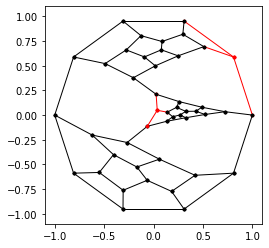

In [8]:
#find the biggest cycle in G
all_loops = [list(nx.find_cycle(G, source=v)) for v in G.nodes]

a = sorted(all_loops, key = lambda s: len(s)) 
longest_cycle = a[-1]
print(f"longest cycle: {longest_cycle}")

#find node nearest to center of embedding
PlanarEmbed(G, 256, outerCycle=[e[0] for e in longest_cycle]) #since already calculated, reuse
coordinates = [(v, G.nodes[v]["position"]) for v in G.nodes]

b = sorted(coordinates, key = lambda c: np.linalg.norm(c[1])) 
closest_to_origin = b[0][0]

#make this node t
t = closest_to_origin
print(f"t: {t}")

#select a node farthest from t in longest cycle to be s. 
s = random.choice(longest_cycle)[0] #change this random sampling
print(f"s: {s}")

PlotGraph(G, s=s, t=t)


Execution 

---
`PAR_STN` implemented, fully working

In [10]:
#Execution: create st-orientation of G
Q = {s}
m = np.full(G.number_of_nodes(), 0, dtype=int)
f = np.full(G.number_of_nodes(), 0, dtype=int)
j = 0
F = nx.DiGraph()

G1 = G.copy()
PAR_STN(G1, s, 0.5) #change the parameter p here

print(f"s, t: {s}, {t}")
print(f"st-numbering: {f}")
print(f"G number of nodes, edges: {G.number_of_nodes()}, {G.number_of_edges()}")
print(f"F number of nodes, edges: {F.number_of_nodes()}, {F.number_of_edges()}")

s, t: 1, 22
st-numbering: [24  1 26 22  4  5 14 25 27 32 30 29 38 39 28 45 44 42 23 21 17 16 46 15
 10  9  2 13 12  6  7  8 11  3 34 37 36 35 33 31 40 18 19 41 43 20]
G number of nodes, edges: 46, 69
F number of nodes, edges: 46, 69


Visualization 


---


Working! Sink t isnt uniquely colored since plotting uses edges. Now always with longest possible outer face.

A change: since we embedded G earlier, we use it to embed F for free

s, t: 1, 22
is DAG: True
longest path (length 31): [1, 26, 33, 4, 5, 29, 30, 31, 25, 24, 32, 28, 27, 23, 21, 20, 41, 42, 45, 19, 3, 0, 2, 10, 9, 37, 36, 35, 12, 13, 15, 22]
shortest path (length 6): [1, 26, 25, 24, 23, 21, 22]
source: [1]
sink: [22]


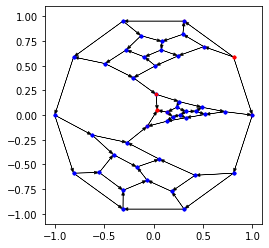

In [11]:
for v in G.nodes:
    for attribute in G.nodes[v]:
        F.nodes[v][attribute] = G.nodes[v][attribute] #set the embed attributes in directed graph

PlotDirectedGraph(F, s, t) #plot directed graph

longest_path = dag.dag_longest_path(F)
shortest_path = nx.shortest_path(F, source=s, target=t)

print(f"s, t: {s}, {t}")
print(f"is DAG: {nx.is_directed_acyclic_graph(F)}")
print(f"longest path (length {len(longest_path)-1}): {longest_path}")
print(f"shortest path (length {len(shortest_path)-1}): {shortest_path}")
print(f"source: {[v for v in F.nodes if F.in_degree(v)==0]}")
print(f"sink: {[v for v in F.nodes if F.out_degree(v)==0]}")

#References


 
---
 
B. Plestenjak, 'An Algorithm for Drawing Planar Graphs' https://www.fmf.uni-lj.si/~plestenjak/Papers/schlegel
 
C. Papamanthou, I. G. Tollis, 'Algorithms for computing a parameterized st-orientation' https://www.researchgate.net/publication/220149886_Algorithms_for_computing_a_parameterized_st-orientation

H. Fraysseix et al, 'Bipolar Orientations Revisited' https://www.sciencedirect.com/science/article/pii/0166218X9400085R

J. P. Costalonga et al, 'Constructing minimally 3-connected graphs' https://arxiv.org/abs/2012.12059

W. T. Tutte, 'A Theory of 3-Connected Graphs' https://core.ac.uk/download/pdf/82624113.pdf
